In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython
import pandas as pd
import pickle

import os
os.chdir("F:\M2\Interpretable-TimeSeries-Classification")

## Importing data

In [57]:
dataloc  = "Data/genres_original/"

genres = os.listdir(dataloc)

musiclist = []
genrelist = []
srlist = []

musictrain = []
genretrain = []
srtrain = []
musictest = []
genretest = []
srtest = []

print("Reading songs")
for genre in genres:
    for i, music in enumerate(os.listdir(dataloc + genre)):
        try:
            music_time_series, sr = librosa.load(dataloc + genre + "/" + music)
        except Exception as e:
            print(f"Error loading {music}: {e}")
            continue
        srlist.append(sr)
        musiclist.append(music_time_series)
        genrelist.append(genre)

        if i<25: # 25-75 test train split
            musictest.append(music_time_series)
            genretest.append(genre)
            srtest.append(sr)
        else:
            musictrain.append(music_time_series)
            genretrain.append(genre)
            srtrain.append(sr)

print("Creating dataframe")
fulldata = pd.DataFrame({'Music': musiclist, 'Genre': genrelist, "SampleRate": srlist})

print("Saving dataframe")
fulldata.to_csv("Data/fulldata.csv", index=False)

print("Saving train and test data")
train = pd.DataFrame({"Music" : musictrain, "Genre" : genretrain, "SampleRate": srtrain})
test = pd.DataFrame({"Music" : musictest, "Genre" : genretest, "SampleRate": srtest})

with open("Data/train.pkl", "wb") as f:
    pickle.dump(train, f)

with open("Data/test.pkl", "wb") as f:
    pickle.dump(test, f)

Reading songs


C:\Users\melvi\AppData\Local\Temp\ipykernel_2880\2820360306.py:20: UserWarning: PySoundFile failed. Trying audioread instead.
  music_time_series, sr = librosa.load(dataloc + genre + "/" + music)


Error loading jazz.00054.wav: 
Creating dataframe
Saving dataframe
Saving train and test data


In [2]:
with open("Data/train.pkl", "rb") as f:
    train = pickle.load(f)

with open("Data/test.pkl", "rb") as f:
    test = pickle.load(f)

## SAX Implementation

In [3]:
alphabet = np.array(["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"])

def SAX(time_series, w, alpha):
    time_series = np.array(time_series)
    time_series = (time_series - np.mean(time_series)) / np.std(time_series)

    # PAA
    PAA=[]
    for word_index in range(w):
        ceiling = min(len(time_series), int((word_index+1)*len(time_series)/w))
        PAA.append(np.mean(time_series[int(word_index*len(time_series)/w):ceiling]))
    
    lookup = np.quantile(time_series, np.arange(1,alpha)*(1/alpha) )
    
    sax = np.digitize(PAA, lookup)

    return list(sax)

def SAX_window(time_series, w, alpha, l):
    L = len(time_series)
    sax_sentence = []
    previous_word = np.full(w,-1)

    for i in range(0, (L-l+1), l//2):
        ceiling = min(L, (i+1)*l)
        sax_word = SAX(time_series[i : ceiling], w, alpha)

        npsaxword = np.array(sax_word)
        if np.sum(npsaxword - previous_word) == 0: # Remove repeated words for reasons
            continue
        
        if i > 0:
            sax_sentence.append(" ")
        sax_sentence.extend(sax_word)
        previous_word = sax_word

    phrase = ""
    for letter in sax_sentence:
        if isinstance(letter, np.int64):
            phrase += alphabet[letter]
        else :
            phrase += letter
    return phrase

In [61]:
# Tried a parallelized version for increment 1, gets OOM
"""def SAX_window(time_series, w, alpha, l):
    L = len(time_series)
    sax_sentence = []
    previous_word = np.full(w,-1)

    all_windows= np.empty((l,L - l + 1))
    for i in range(0, L-l+1):
        print(i)
        ceiling = i+l
        all_windows[i] = time_series[i : ceiling]

    allsax = np.apply_along_axis(SAX, 0, all_windows)
    print(allsax.shape)

    phrase = ""
    for letter in sax_sentence:
        if isinstance(letter, np.int64):
            phrase += alphabet[letter]
        else :
            phrase += letter
    return phrase"""

In [89]:
nptrainmusic = train["Music"].to_numpy()

selected_index = 81
selected_music = nptrainmusic[selected_index]

# Pre-process eliminating noise
#testmusic = librosa.effects.preemphasis(testmusic)

sentence = SAX_window(selected_music, w = 16, alpha = 4, l = int(.2*len(selected_music)+1 ))
print(sentence)

ccccbccccccbcbcb cccccccccccccccc cccccccbcccccccc cccccccccccccccc cbcccccccccccccc cccccccccccccbbb


## SFA Implementation

In [20]:
alpha = 4
w , halfw= 4, 2

DFT_base_length4 = np.empty((len(nptrainmusic), w))

for i, music in enumerate(nptrainmusic):
    fft = np.fft.fft(music)
    halfw_real = np.real(fft[:halfw])
    halfw_complex = np.imag(fft[:halfw])
    
    DFT_base_length4[i] = np.array([halfw_real[0], halfw_complex[0], halfw_real[1], halfw_complex[1]]) # Shitty inefficient, can be made with np.apply_along_axis

q =  np.arange(1,alpha)*(1/alpha)

SFA_breakpoints = np.quantile(DFT_base_length4, q, axis=0)


In [4]:
def SFA(time_series, alpha=alpha, w=w, lookup=SFA_breakpoints):
    fft = np.fft.fft(time_series)
    halfw = w//2
    halfw_real = np.real(fft[:halfw])
    halfw_complex = np.imag(fft[:halfw])
    coefs = np.array([halfw_real[0], halfw_complex[0], halfw_real[1], halfw_complex[1]])

    sfa=np.empty(w, dtype=np.int64)
    for i, coef in enumerate(coefs):
        sfa[i] = np.digitize(coef, lookup[:,i]) * (i+1) # *(i+1) to make sure same indices for different coefficients don't get the same symbol

    return sfa

def SFA_window(time_series, l, alpha=alpha, w=w, lookup=SFA_breakpoints):
    L = len(time_series)
    sfa_sentence = []
    previous_word = np.full(w,-1)

    for i in range(0, L, l): # Non-overlapping windows for this one
        ceiling = min(L, (i+1)*l) 
        sfa_word = SFA(time_series[i : ceiling], w, alpha, lookup=lookup)

        npsfaword = np.array(sfa_word)
        if np.sum(npsfaword - previous_word) == 0: # Remove repeated words for reasons
            continue
        
        if i > 0:
            sfa_sentence.append(" ")
        sfa_sentence.extend(sfa_word)
        previous_word = sfa_word

    phrase = ""
    for letter in sfa_sentence:
        if isinstance(letter, np.int64):
            phrase += alphabet[letter]
        elif letter == " ":
            phrase += letter
        else:
            raise ValueError("error, got letter", letter)
    return phrase

NameError: name 'alpha' is not defined

In [82]:
selected_index = 162
selected_music = nptrainmusic[selected_index]

print(SFA_window(selected_music, l=int(.2*len(selected_music+1))))

dagi dgdi dagi dedi dede dege


## Stuff

In [248]:
class SEQL:
    def __init__(self, C=1.0, alpha=0.5, convergence_threshold=1e-5, max_iterations=1000):
        self.C = C
        self.alpha = alpha
        self.convergence_threshold = convergence_threshold
        self.max_iterations = max_iterations
        self.beta = None
        self.best_feature = None
        self.index_to_feature = []
        self.bigX = []

    def _compute_regularization_gradient(self, beta):
        """Elastic-net gradient."""
        return self.alpha * np.sign(beta) + (1 - self.alpha) * beta

    def _compute_loss_gradient(self, X, y, beta):
        """Compute gradients for all features."""
        margins = y * (X @ beta)
        probabilities = -1 / (1 + np.exp(margins))
        gradients = X.T @ (y * probabilities) / len(y)
        return gradients
    
    def _line_search(self, X, y, beta, gradients, best_gradient_index):
        """Perform a line search to find the optimal step size for updating beta."""
        old_margins = y * (X @ beta)
        old_loss = np.mean(np.log(1 + np.exp(-old_margins))) + self.C * (
            self.alpha * np.sum(np.abs(beta)) + (1 - self.alpha) * 0.5 * np.sum(beta ** 2)
        )

        step_size = 1.0
        while step_size > 1e-10:
            new_beta = beta.copy()
            new_beta[best_gradient_index] -= step_size * gradients[best_gradient_index]
            new_margins = y * (X @ new_beta)
            new_loss = np.mean(np.log(1 + np.exp(-new_margins))) + self.C * (
                self.alpha * np.sum(np.abs(new_beta)) + (1 - self.alpha) * 0.5 * np.sum(new_beta ** 2)
            )
            
            if new_loss <= old_loss + 1e-10:
                return step_size
            step_size *= 0.5
        
        print("Failed line search")
        return 1e-10  # Return a small constant to prevent zero step size
    


    def fit(self, representations, y, nb_classes = False, plot_grads = False, verbose = False):
        """
        representations : symbolic representations of the whole training set using the same discretization method and parameters
        y : labels to predict
        """
        if not nb_classes:
            nb_classes = max(y)+1
        y_one_hot = np.zeros((len(y), nb_classes))
        y_one_hot[np.arange(len(y)), y] = 1

        # Extract unigrams from the representations
        feature_map = {char: idx for idx, char in enumerate(set(''.join(representations).replace(' ', '')))} # initialize unigrams and their ID
        map_features = [char for char in feature_map.keys()]
        nb_new_features = len(feature_map)

        # Initialize feature matrix
        X = np.zeros((len(representations), len(feature_map)))

        # Build initial feature matrix
        for i, seq in enumerate(representations):
            for feature in feature_map:
                X[i, feature_map[feature]] = seq.count(feature)

        num_features = X.shape[1]
        self.beta = np.zeros(num_features)

        if plot_grads: best_grads=[]

        for iteration in range(self.max_iterations):
            #Compute gradients
            loss_gradients = self._compute_loss_gradient(X, y, self.beta) 
            regu_gradients = self._compute_regularization_gradient(self.beta) * self.C
            gradients = loss_gradients + regu_gradients

            best_gradient = np.max(abs(gradients))
            best_gradient_index = np.argmax(abs(gradients))
            best_grads.append(best_gradient)

            if np.sum(X[:, best_gradient_index]) == 0: #If the feature is not present in the dataset
                print("Problem at iteration", iteration)
                print("Best gradient :", best_gradient)
                print("Sum gradients :", gradients.sum()) 
                raise ValueError("Best feature not present in dataset")

            if verbose : print("Iteration",iteration,", best gradient :", best_gradient)

            #Stopping condition
            if best_gradient < self.convergence_threshold :
                break

            #Expand features
            new_features = set()

            for feature_idx in range(num_features-1, num_features- nb_new_features-1, -1): #Only extend features added during last iteration
                subseq = map_features[feature_idx]
                for seq in representations[X[:,feature_idx] > 0]: #Only consider sequences where the feature is present
                    found = seq.find(subseq)
                    while found>=0:
                        if found + len(subseq) + 1 >= len(seq): #Don't cross over the end of the sequence
                            break

                        newchar = seq[found + len(subseq) + 1]
                        if newchar != ' ': #Don't cross over several words
                            new_features.add(subseq+newchar)

                        found = seq.find(subseq, found+1)
                        
            if verbose : print("Number of new features:", len(new_features))

            #Prune
            upper_bounds = []
            checked_prefixes = [False] * len(feature_map)
            for new_feature in new_features:
                prefix_index = feature_map[new_feature[:-1]]

                if checked_prefixes[prefix_index]:
                    upper_bounds.append(checked_prefixes[prefix_index])
                    continue

                prefix_appearances = X[:, prefix_index] > 1e-10 #indices where the prefix is present
                
                boundmax = 0
                for classe in [-1,1]:
                    check_indices = (prefix_appearances * y==classe)
                    bound = np.sum((-classe * 1/(1+np.exp(classe * X[check_indices, :] @ self.beta)))) 
                    bound+= regu_gradients[prefix_index]
                    bound = abs(bound)
                    if bound > boundmax:
                        boundmax = bound

                upper_bounds.append(boundmax)
                checked_prefixes[prefix_index] = boundmax
            
            prune = upper_bounds <= best_gradient
            nb_new_features = len(new_features) - np.sum(prune)

            for i,feature in enumerate(new_features):
                if prune[i]: continue
                map_features.append(feature)
                feature_map[feature] = len(feature_map)

            num_features = len(feature_map)
            new_X = np.zeros((len(representations), nb_new_features)) # There is a way to do feature expansion, pruning and X update all within the same loop, do later
            X = np.block([X, new_X])
            
            nb_previous_features = num_features - nb_new_features
            for i, seq in enumerate(representations):
                nonpruned=0
                for j, feature in enumerate(new_features):
                    if prune[j]: continue
                    X[i, nb_previous_features+nonpruned ] = seq.count(feature)
                    nonpruned+=1
            
            self.beta = np.append(self.beta, np.zeros(nb_new_features)) # Add 0 coefs to new features
            step_size = self._line_search(X, y, self.beta, gradients, best_gradient_index) 
            self.beta[best_gradient_index] -= step_size * gradients[best_gradient_index] # Update beta

            if verbose : 
                print("Number of features after pruning:", X.shape[1],",",np.sum(prune),"features pruned")
                print("Gradient Upper bounds :", upper_bounds)

        #Append selected features to selected features list
        self.index_to_feature.extend(map_features)
        
        if not len(self.bigX):
            self.bigX = X
        else :
            self.bigX = np.block([self.bigX, X])

        if plot_grads:
            plt.title("Best gradient per iteration")
            plt.xlabel("Iteration")
            plt.ylabel("Best gradient")
            plt.plot(best_grads)
            plt.grid('yes')
            plt.show()

    def predict(self, representations):
        # Build feature matrix
        X = np.zeros((len(representations), len(self.index_to_feature)))
        for i, seq in enumerate(representations):
            for feature in self.index_to_feature:
                X[i, self.index_to_feature.index(feature)] = seq.count(feature)

        return np.sign(X @ self.beta)
    
    def predict_probas(self, representations):
        # Build feature matrix
        X = np.zeros((len(representations), len(self.index_to_feature)))
        for i, seq in enumerate(representations):
            for feature in self.index_to_feature:
                X[i, self.index_to_feature.index(feature)] = seq.count(feature)

        return X @ self.beta
    
    def score(self, representations, y):
        return np.mean(self.predict(representations) == y)
            

In [141]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data

y = data.target
# Convert labels from {0, 1} to {-1, 1}
y = 2 * y - 1

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)
print("First 5 labels:", y[:5])

cancer_sax = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_train])
cancer_sax_test = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in X_test])

Dataset shape: (569, 30)
Labels shape: (569,)
First 5 labels: [-1 -1 -1 -1 -1]


c:\ProgramData\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Iteration 0 , best gradient : 6.097417840375587
Number of new features: 16
Number of features after pruning: 20 , 0 features pruned
Gradient Upper bounds : [134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0, 134.0]
Iteration 1 , best gradient : 1.2929124263856098
Number of new features: 64
Number of features after pruning: 84 , 0 features pruned
Gradient Upper bounds : [102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 101.26079138576682, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 68.27288143792234, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 102.56089593707077, 68.27288143792234, 68.27288143792234, 102.56089593707077, 101.260791385766

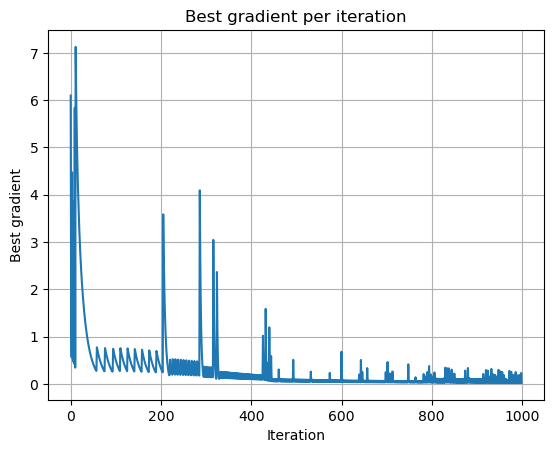

Train accuracy: 0.8802816901408451
Test accuracy: 0.9020979020979021


In [251]:
seql = SEQL(convergence_threshold=.002, max_iterations=1000, C=0)
seql.fit(cancer_sax, y_train, plot_grads=True, verbose =True)

print("Train accuracy:", seql.score(cancer_sax, y_train))
print("Test accuracy:", seql.score(cancer_sax_test, y_test))

In [252]:
print(seql.predict(cancer_sax_test))

[ 1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.
  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.
  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1. -1.
 -1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1.]


In [ ]:
train_sax = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in train['Music']])
train_labels = np.array(train['Genre'])

genres = np.unique(train_labels)
genre_to_index = {genre : index for index, genre in enumerate(genres)}

train_labels = [genre_to_index[label] for label in train_labels]

test_sax = np.array([SAX_window(ts, w=16, alpha=4, l = int(0.2*len(ts))+1 ) for ts in test['Music']])
test_labels = np.array(test['Genre'])

test_labels = [genre_to_index[label] for label in test_labels]

In [63]:
# ChatGPT code, not even sure what this is

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# Function to convert time series to SAX representation
def time_series_to_sax(time_series, w, alpha):
    return ' '.join(map(str, SAX_window(time_series, w, alpha, int(.2*len(time_series)+1))))

# Convert the training and test data to SAX representation
train_sax = [time_series_to_sax(ts, w=16, alpha=4) for ts in train['Music']]
train_labels = train['Genre']
test_sax = [time_series_to_sax(ts, w=16, alpha=4) for ts in test['Music']]

# Filter out empty SAX representations and corresponding labels
train_sax, train_labels = zip(*[(sax, label) for sax, label in zip(train_sax, train['Genre']) if sax.strip()])
test_sax, test_labels = zip(*[(sax, label) for sax, label in zip(test_sax, test['Genre']) if sax.strip()])

# Create a pipeline with CountVectorizer and LogisticRegression
seql_pipeline = make_pipeline(
    CountVectorizer(),
    LogisticRegression(max_iter=1000)
)

# Train the model
print("Training the model")
seql_pipeline.fit(train_sax, train_labels)

# Predict on the test set
test_predictions = seql_pipeline.predict(test_sax)

# Evaluate the model
accuracy = (test_predictions == test_labels).mean()
print(f"Test Accuracy: {accuracy:.2f}")

Training the model


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
# ChatGPT code 

class SEQL:
    def __init__(self, C=1.0, alpha=0.5, convergence_threshold=1e-5, max_iterations=1000):
        self.C = C
        self.alpha = alpha
        self.convergence_threshold = convergence_threshold
        self.max_iterations = max_iterations
        self.beta = None
        self.best_feature = None

    def _compute_regularization_gradient(self, beta_j):
        """Elastic-net gradient."""
        return self.alpha * np.sign(beta_j) + (1 - self.alpha) * beta_j

    def _compute_loss_gradient(self, X, y, beta):
        """Compute gradients for all features."""
        margins = y * (X @ beta)
        probabilities = 1 / (1 + np.exp(margins))
        gradients = X.T @ (y * probabilities) / len(y)
        return gradients

    def _prune(self, prefix_gradient, current_best):
        """Prune if the bound indicates no improvement."""
        return np.abs(prefix_gradient) < current_best

    def _expand_features(self, sequences, feature_map):
        """Iteratively expand features from unigrams."""
        expanded_features = set(feature_map.keys())
        for seq in sequences:
            for i in range(len(seq)):
                for j in range(i + 1, len(seq) + 1):
                    feature = seq[i:j]
                    if ' ' in feature:
                        continue  # Skip features containing spaces
                    if feature not in expanded_features:
                        feature_map[feature] = len(feature_map)
                        expanded_features.add(feature)
        return feature_map

    def fit(self, sequences, y):
        """
        Fit SEQL model.
        - sequences: List of input sequences.
        - y: Binary labels (-1, 1).
        """
        # Start with unigrams
        feature_map = {char: idx for idx, char in enumerate(set(''.join(sequences)))}
        X = np.zeros((len(sequences), len(feature_map)))

        # Build initial feature matrix
        for i, seq in enumerate(sequences):
            for feature in feature_map:
                X[i, feature_map[feature]] = seq.count(feature)

        num_features = X.shape[1]
        self.beta = np.zeros(num_features)

        for iteration in range(self.max_iterations):
            best_gradient = 0
            best_feature = None

            # Traverse features to find the best gradient
            for feature, idx in feature_map.items():
                gradient = np.sum(
                    y * X[:, idx] * (1 / (1 + np.exp(y * (X @ self.beta))))
                ) / len(y)
                gradient += self.C * self._compute_regularization_gradient(self.beta[idx])

                # Update best feature
                if np.abs(gradient) > best_gradient:
                    best_gradient = np.abs(gradient)
                    best_feature = feature

            # Stopping condition
            if best_gradient < self.convergence_threshold:
                print("Converged after", iteration, "iterations.")
                break

            # Update selected feature
            idx = feature_map[best_feature]
            step_size = best_gradient  # Simplified; refine with line search if needed
            self.beta[idx] -= step_size

            # Expand feature map iteratively
            feature_map = self._expand_features(sequences, feature_map)
            new_X = np.zeros((len(sequences), len(feature_map)))
            for i, seq in enumerate(sequences):
                for feature in feature_map:
                    new_X[i, feature_map[feature]] = seq.count(feature)
            X = new_X
            self.beta = np.zeros(len(feature_map))

        self.best_feature = best_feature

    def predict(self, X):
        """Predict using the learned model."""
        return np.sign(X @ self.beta)

# Example usage
# Sequences should exclude spaces during preprocessing.
sequences = ["abc", "ab", "bc"]  # Example sequences
y = np.array([1, -1, 1])            # Labels

seql = SEQL(C=1.0, alpha=0.5)
seql.fit(train_sax, train_labels)
print("Best feature:", seql.best_feature)


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U9'), dtype('float64')) -> None